# Advanced Data Visualization With Plotnine And Plotly

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile
from kaggle.api.kaggle_api_extended import KaggleApi
import plotly.express as px
import plotly.graph_objects as go
pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
def download_and_read_csv(dataset_link):
    api = KaggleApi()
    api.authenticate()
    api.dataset_download_files(dataset_link, path=".", unzip=True)
    files = os.listdir()

In [3]:
download_and_read_csv('unsdsn/world-happiness')

In [4]:
df_2019 = pd.read_csv('2019.csv')
df = df_2019.copy()
df.head()

,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,1,Finland,7.77,1.34,1.59,0.99,0.60,0.15,0.39
1,2,Denmark,7.60,1.38,1.57,1.00,0.59,0.25,0.41
2,3,Norway,7.55,1.49,1.58,1.03,0.60,0.27,0.34
3,4,Iceland,7.49,1.38,1.62,1.03,0.59,0.35,0.12
4,5,Netherlands,7.49,1.40,1.52,1.00,0.56,0.32,0.30


# Data Loading and Preprocessing:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Overall rank                  156 non-null    int64  
 1   Country or region             156 non-null    object 
 2   Score                         156 non-null    float64
 3   GDP per capita                156 non-null    float64
 4   Social support                156 non-null    float64
 5   Healthy life expectancy       156 non-null    float64
 6   Freedom to make life choices  156 non-null    float64
 7   Generosity                    156 non-null    float64
 8   Perceptions of corruption     156 non-null    float64
dtypes: float64(7), int64(1), object(1)
memory usage: 11.1+ KB


In [6]:
df.isnull().sum() # no missings

Overall rank                    0
Country or region               0
Score                           0
GDP per capita                  0
Social support                  0
Healthy life expectancy         0
Freedom to make life choices    0
Generosity                      0
Perceptions of corruption       0
dtype: int64

In [7]:
df.duplicated().sum() # no duplicated rows

0

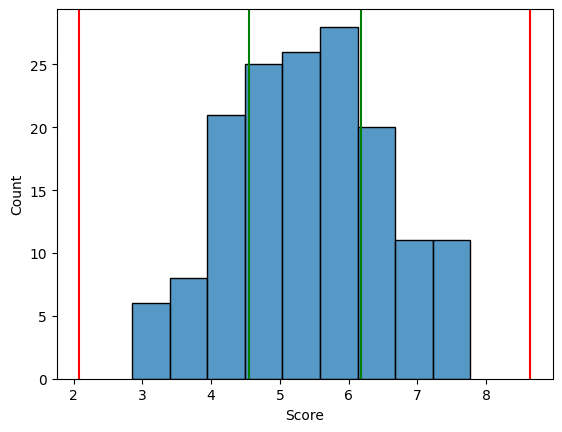

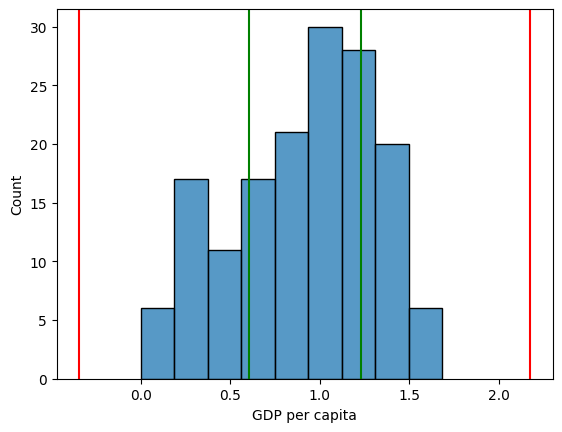

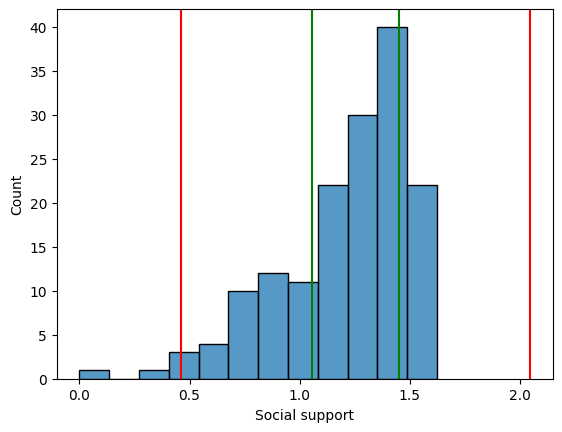

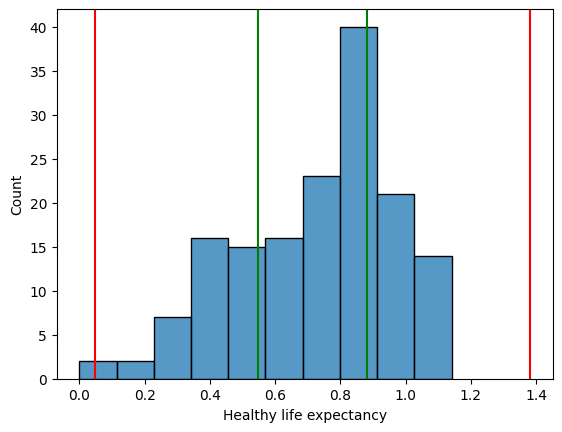

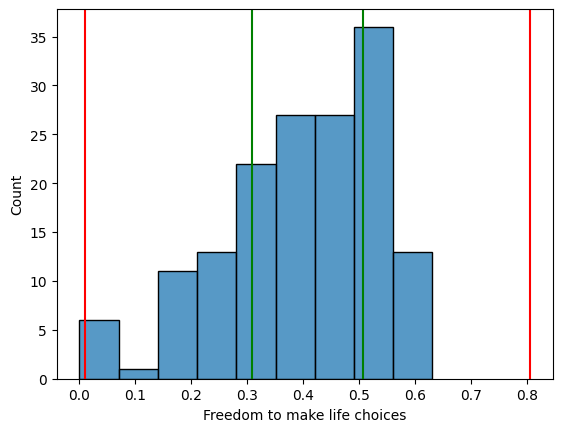

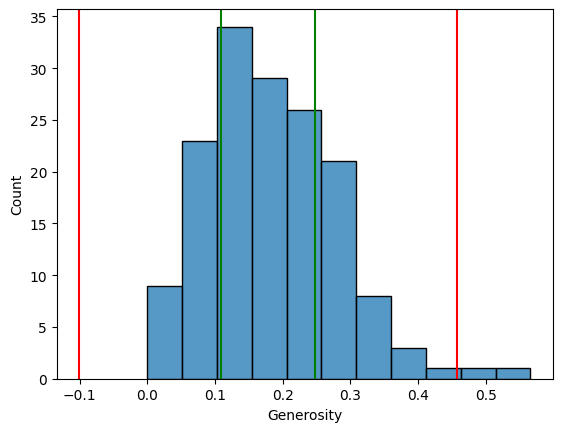

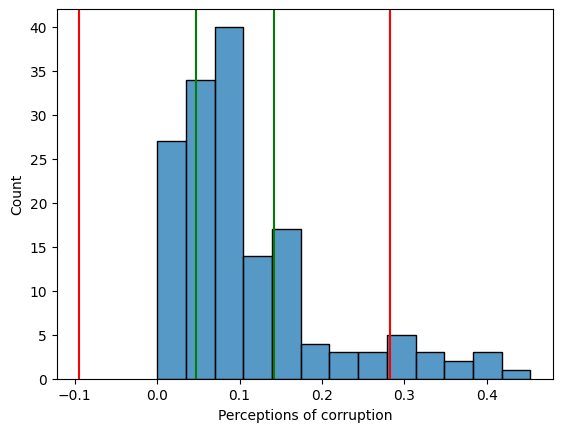

In [8]:
numeric_columns = ['Score', 'GDP per capita', 'Social support', 'Healthy life expectancy', 'Freedom to make life choices', 'Generosity', 'Perceptions of corruption']
# finding the Quantiles:
for col in numeric_columns:
    Q1 = df[col].quantile(0.25)
    Q2 = df[col].quantile(0.50)
    Q3 = df[col].quantile(0.75)

    # IQR : Inter-Quartile Range
    IQR = Q3 - Q1
    # Lower Limit:
    LC = Q1 - (1.5*IQR)
    # Upper Limit:
    UC = Q3 + (1.5*IQR)
    # display(LC)
    # display(UC)

    sns.histplot(df[col])
    plt.axvline(UC, color='r')
    plt.axvline(LC, color='r')
    plt.axvline(Q1, color='g')
    plt.axvline(Q3, color='g')
    plt.show()

In [9]:
# we have outliers in Generosity and Perceptions of corruption.

In [10]:
class OutlierHandler:
    def __init__(self, df):
        self.df = df.copy()

    def remove_outliers(self, col_name, lower_bound, upper_bound):
        self.df = self.df[(self.df[col_name] >= lower_bound) & (self.df[col_name] <= upper_bound)]

    def check_outliers(self):
        column_list = self.df.select_dtypes(include=['number', 'float', 'integer']).columns
        print("numeric columns: ", column_list)
        for col_name in column_list:
            Q1 = self.df[col_name].quantile(0.25)
            Q3 = self.df[col_name].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            self.remove_outliers(col_name, lower_bound, upper_bound)
        return self.df

# Assuming df is your DataFrame containing the data
outlier_handler = OutlierHandler(df)
df_clean = outlier_handler.check_outliers()
print(df_clean.shape)

numeric columns:  Index(['Overall rank', 'Score', 'GDP per capita', 'Social support',
       'Healthy life expectancy', 'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption'],
      dtype='object')
(133, 9)


In [11]:
df_clean

,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
3,4,Iceland,7.49,1.38,1.62,1.03,0.59,0.35,0.12
9,10,Austria,7.25,1.38,1.48,1.02,0.53,0.24,0.23
11,12,Costa Rica,7.17,1.03,1.44,0.96,0.56,0.14,0.09
12,13,Israel,7.14,1.28,1.46,1.03,0.37,0.26,0.08
14,15,United Kingdom,7.05,1.33,1.54,1.00,0.45,0.35,0.28
...,...,...,...,...,...,...,...,...,...
146,147,Haiti,3.60,0.32,0.69,0.45,0.03,0.42,0.11
147,148,Botswana,3.49,1.04,1.15,0.54,0.46,0.03,0.10
149,150,Malawi,3.41,0.19,0.56,0.49,0.44,0.22,0.09
150,151,Yemen,3.38,0.29,1.16,0.46,0.14,0.11,0.08


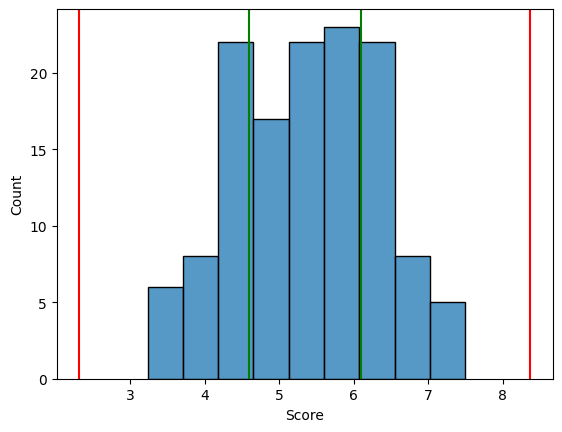

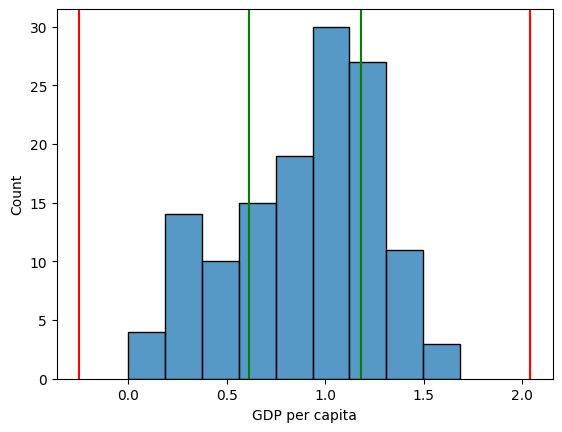

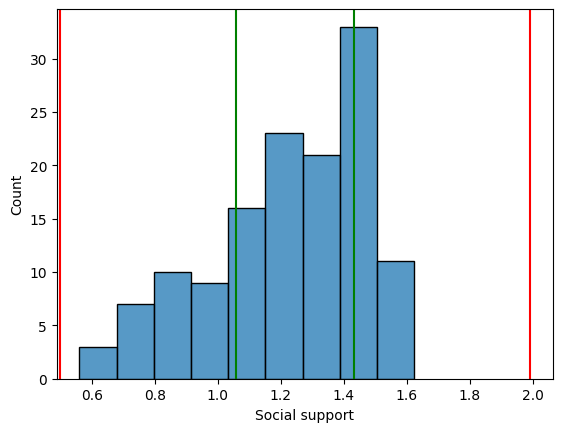

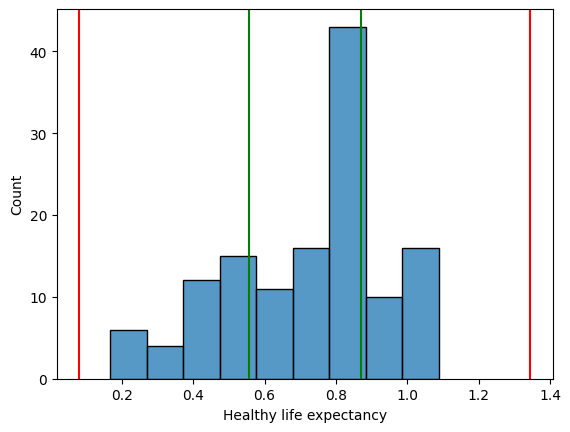

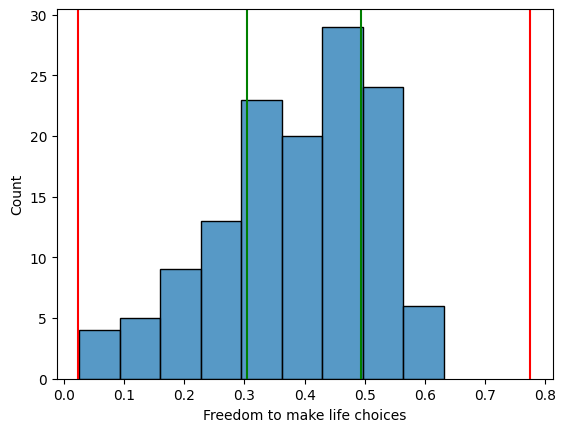

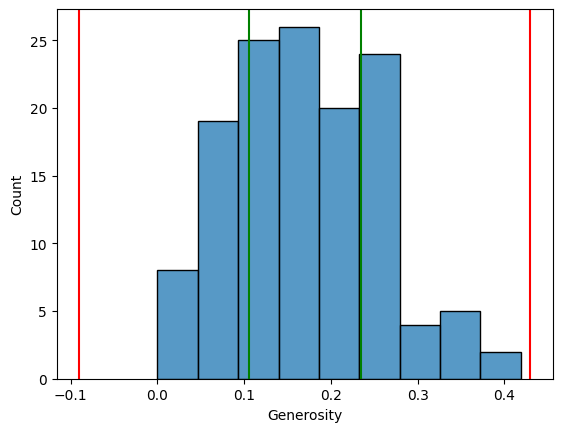

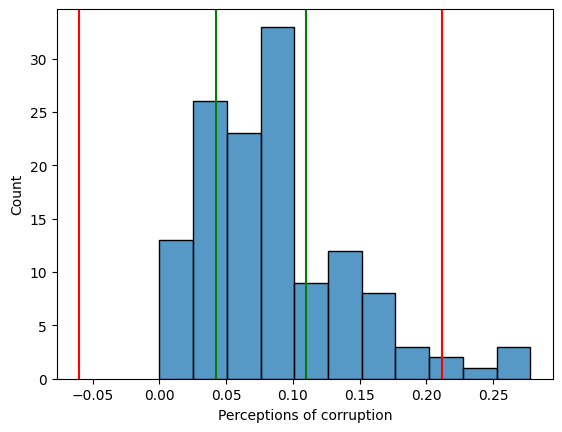

In [12]:
for col in numeric_columns:
    Q1 = df_clean[col].quantile(0.25)
    Q2 = df_clean[col].quantile(0.50)
    Q3 = df_clean[col].quantile(0.75)

    # IQR : Inter-Quartile Range
    IQR = Q3 - Q1
    # Lower Limit:
    LC = Q1 - (1.5*IQR)
    # Upper Limit:
    UC = Q3 + (1.5*IQR)
    # display(LC)
    # display(UC)

    sns.histplot(df_clean[col])
    plt.axvline(UC, color='r')
    plt.axvline(LC, color='r')
    plt.axvline(Q1, color='g')
    plt.axvline(Q3, color='g')
    plt.show()

# Exploratory Data Analysis (EDA):

In [13]:
df_clean.describe()

,Overall rank,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
count,133.00,133.00,133.00,133.00,133.00,133.00,133.00,133.00
mean,80.32,5.36,0.89,1.22,0.72,0.39,0.17,0.09
std,40.74,0.94,0.37,0.25,0.22,0.13,0.09,0.06
min,4.00,3.23,0.00,0.56,0.17,0.03,0.00,0.00
25%,46.00,4.59,0.61,1.06,0.56,0.30,0.10,0.04
50%,80.00,5.34,0.96,1.27,0.79,0.40,0.17,0.08
75%,115.00,6.10,1.18,1.43,0.87,0.49,0.23,0.11
max,153.00,7.49,1.68,1.62,1.09,0.63,0.42,0.28


In [22]:
df_clean[numeric_columns].corr()

,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
Score,1.00,0.75,0.73,0.74,0.44,0.00,0.17
GDP per capita,0.75,1.00,0.71,0.82,0.23,-0.22,0.07
Social support,0.73,0.71,1.00,0.67,0.28,-0.12,-0.03
Healthy life expectancy,0.74,0.82,0.67,1.00,0.22,-0.16,0.05
Freedom to make life choices,0.44,0.23,0.28,0.22,1.00,0.23,0.31
Generosity,0.00,-0.22,-0.12,-0.16,0.23,1.00,0.24
Perceptions of corruption,0.17,0.07,-0.03,0.05,0.31,0.24,1.00


In [23]:
# i see correlation between: score, GDP, social sup., healthy life expectancy

# Visualization with Plotnine:

C:\Users\kyana\AppData\Local\Temp\ipykernel_14836\192733641.py:32: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


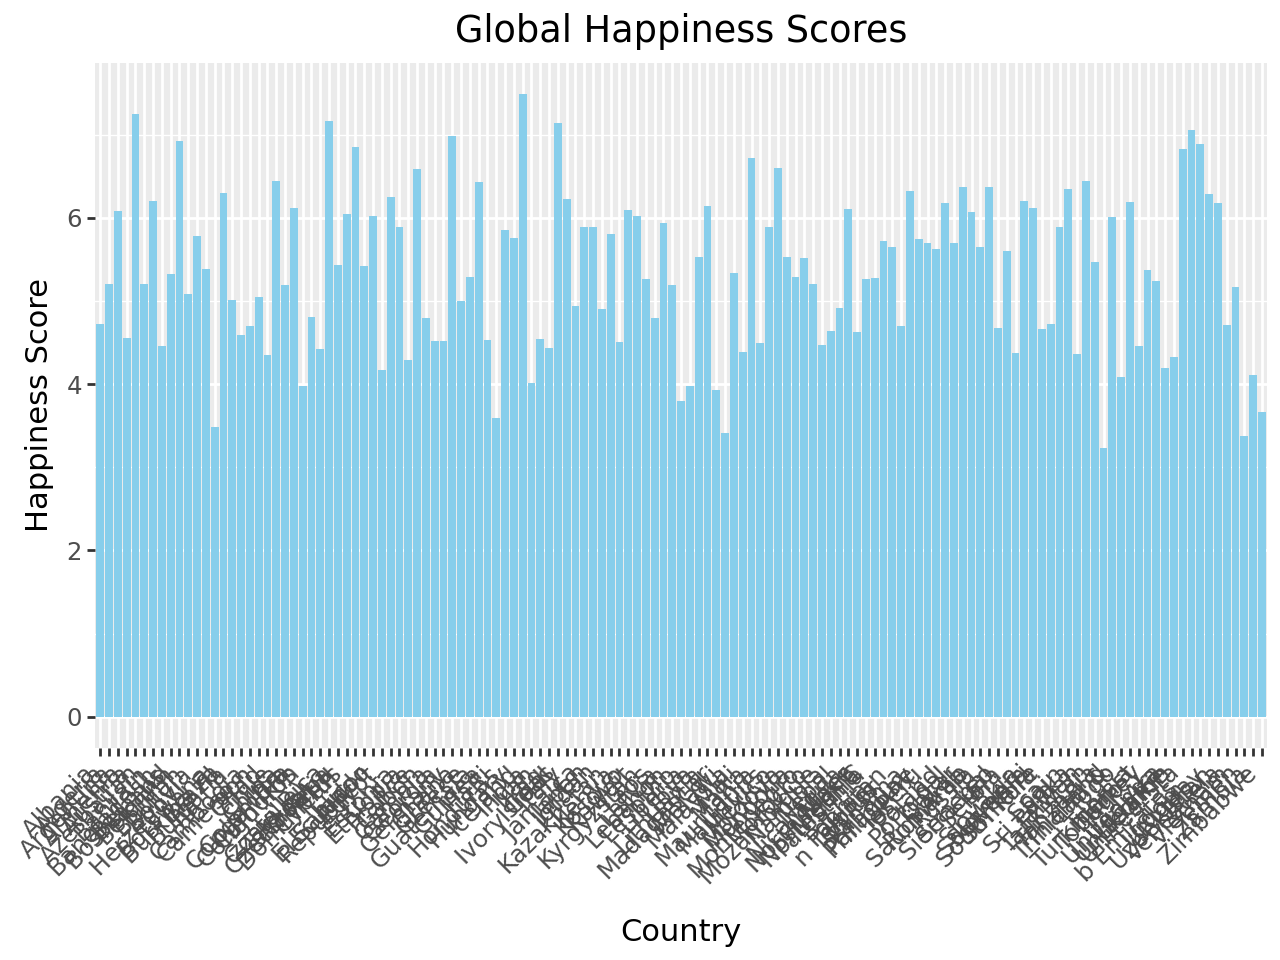

C:\Users\kyana\AppData\Local\Temp\ipykernel_14836\192733641.py:33: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


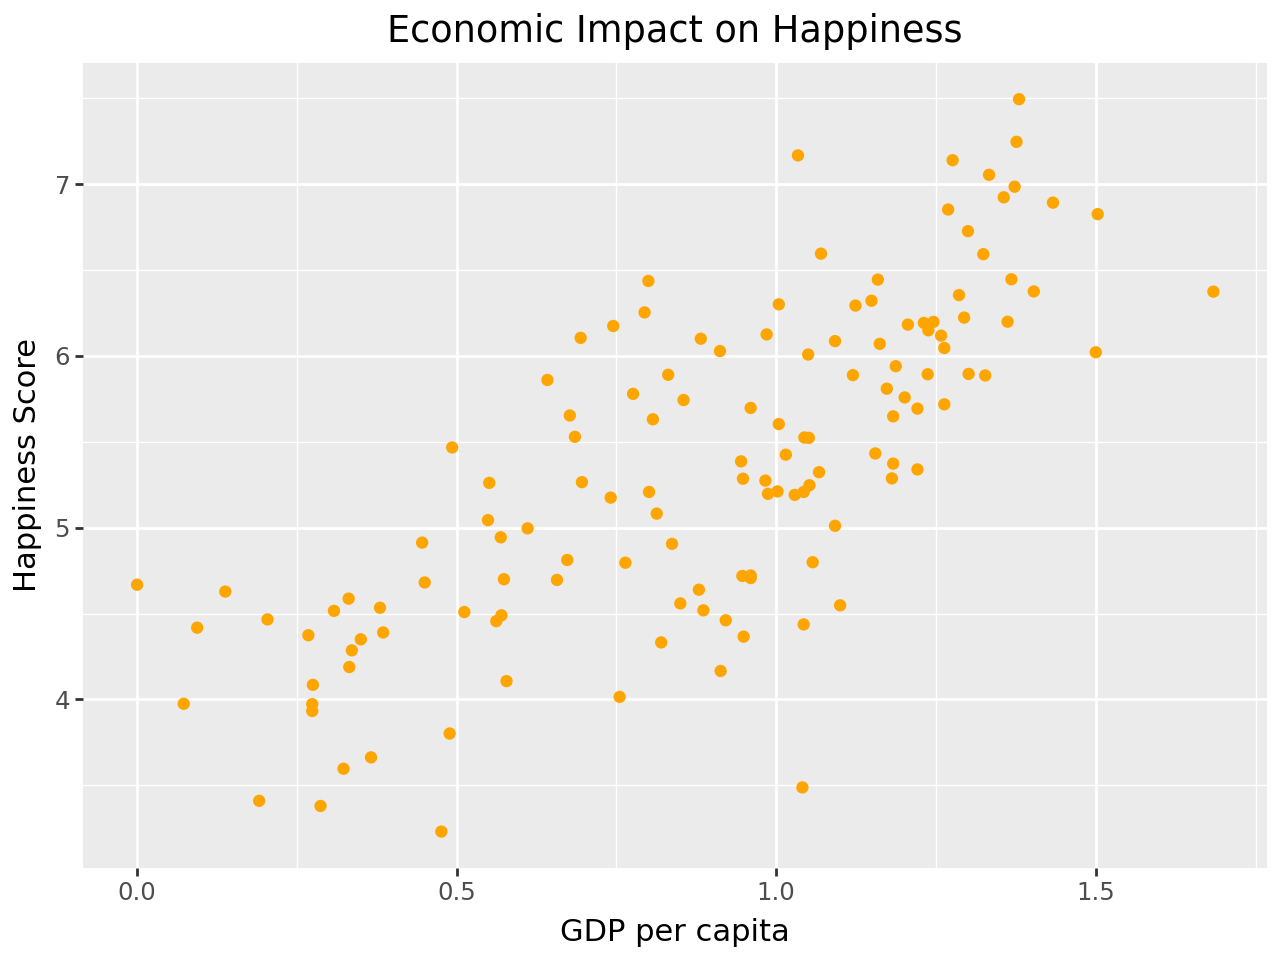

C:\Users\kyana\AppData\Local\Temp\ipykernel_14836\192733641.py:34: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


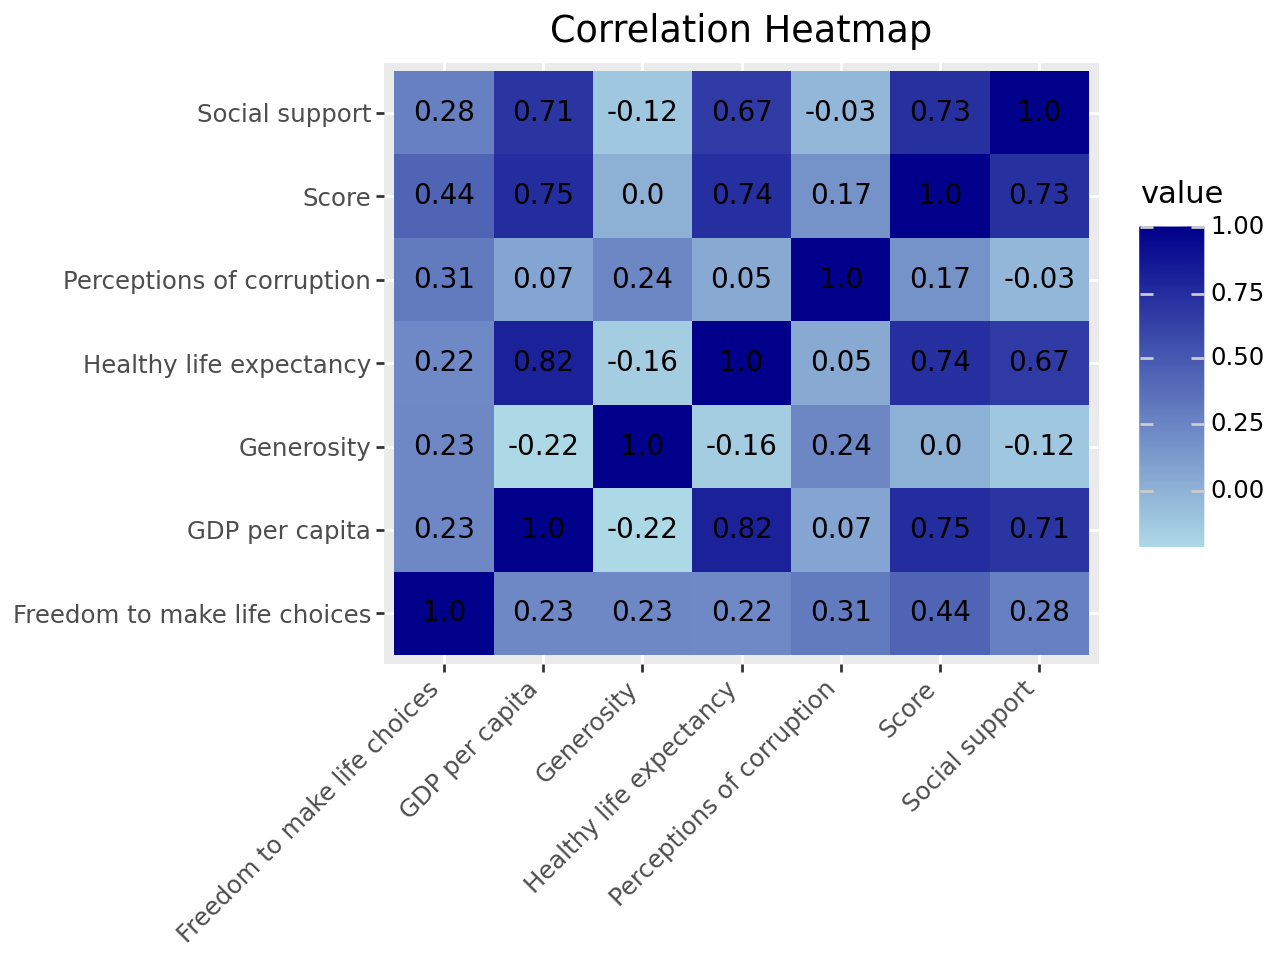

In [39]:
from plotnine import *
# Preprocess data to wrap long country names
df_clean['Country_wrapped'] = df_clean['Country or region'].apply(lambda x: '\n'.join([x[i:i+10] for i in range(0, len(x), 10)]))

# Task 1: Global Happiness Scores - Bar Chart
p1 = (
    ggplot(df_clean, aes(x='Country_wrapped', y='Score')) +
    geom_bar(stat='identity', fill='skyblue') +
    theme(axis_text_x=element_text(rotation=45, hjust=1)) +
    labs(title='Global Happiness Scores', x='Country', y='Happiness Score')
)

# Task 2: Economic Impact on Happiness - Scatter Plot
p2 = (
    ggplot(df_clean, aes(x='GDP per capita', y='Score')) +
    geom_point(color='orange') +
    labs(title='Economic Impact on Happiness', x='GDP per capita', y='Happiness Score')
)

# Task 4: Correlation Heatmap
correlation_matrix = df_clean[numeric_columns].corr()
p4 = (
    ggplot(pd.melt(correlation_matrix.reset_index(), id_vars='index'), aes(x='variable', y='index', fill='value')) +
    geom_tile() +
    geom_text(aes(label='round(value, 2)'), size=10, color='black') +
    scale_fill_gradient(low="lightblue", high="darkblue") +
    theme(axis_text_x=element_text(rotation=45, hjust=1)) +
    labs(title='Correlation Heatmap', x='', y='')
)

# Display plots
print(p1)
print(p2)
print(p4)

In [44]:
# Task 1: Interactive World Map
fig_map = px.choropleth(df_clean, locations='Country or region', locationmode='country names', color='Score',
                        hover_name='Country or region', color_continuous_scale=px.colors.sequential.Blues,
                        title='Happiness Scores Across Countries')
fig_map.show()

In [47]:
df_2019.head()

,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,1,Finland,7.77,1.34,1.59,0.99,0.60,0.15,0.39
1,2,Denmark,7.60,1.38,1.57,1.00,0.59,0.25,0.41
2,3,Norway,7.55,1.49,1.58,1.03,0.60,0.27,0.34
3,4,Iceland,7.49,1.38,1.62,1.03,0.59,0.35,0.12
4,5,Netherlands,7.49,1.40,1.52,1.00,0.56,0.32,0.30


In [46]:
# Task 2: Dynamic Scatter Plot
fig_scatter = px.scatter_matrix(df_clean, dimensions=[numeric_columns])
fig_scatter.show()

In [43]:
# # Task 3: Factor Analysis - Bubble Chart
# fig_bubble = px.scatter(df, x='Social support', y='Generosity', size='Population', color='Score',
#                         hover_name='Country or region', title='Impact of Social Support and Generosity on Happiness',
#                         labels={'Social support': 'Social Support', 'Generosity': 'Generosity'})
# fig_bubble.show()

ValueError: Value of 'size' is not the name of a column in 'data_frame'. Expected one of ['Overall rank', 'Country or region', 'Score', 'GDP per capita', 'Social support', 'Healthy life expectancy', 'Freedom to make life choices', 'Generosity', 'Perceptions of corruption', 'Country_wrapped'] but received: Population

In [16]:
# df['Social support'].corr(df['Score']) # i see a correlation between 'Score' and 'Social support'

In [17]:
# df_CIS = df[df['Country or region'].isin(['Armenia', 'Azerbaijan', 'Belarus', 'Kazakhstan', 'Kirghizstan', 'Moldavia', 'Uzbekistan', 'Russia', 'Tajikistan', 'Turkmenistan', 'Ukraine'])]
# print(df_CIS)


In [18]:
# fig, axes = plt.subplots(2, 1, figsize = (7, 6), sharex=True)
# df_CIS.plot(x = 'Country or region', y = 'GDP per capita', kind = 'bar', ax = axes[0])
# df_CIS.plot(x = 'Country or region', y = 'Healthy life expectancy', kind = 'bar', ax = axes [1])
# plt.show()

In [19]:
# fig, axes = plt.subplots(2, 1, figsize = (10, 8), sharex=True)
# df_CIS.plot(x = 'Country or region', y = 'GDP per capita', kind = 'bar', ax = axes[0])
# df_CIS.plot(x = 'Country or region', y = 'Healthy life expectancy', kind = 'line', ax = axes [1])
# plt.show()